# Experiment from July 2, 2015. Natural Scenes Analysis.
Structure of stimulus:  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
90 min natural scenes  
10 min of 1 min repeating natural scenes  
5 min high contrast white noise

In [55]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording
import pdb
import string
from jetpack.signals import peakdet

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Choose data directory

In [56]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')

# Load photodiode  
To align stimulus and recording. The stimulus is briefly (<500ms) a grey screen, followed by a white photodiode for the first frame.

In [57]:
first_bin_file = data_dir + '150702a.bin'
raw_data = binary.readbin(first_bin_file, chanlist=[0])
header   = binary.readbinhdr(first_bin_file)

In [58]:
header['fs']

10000.0

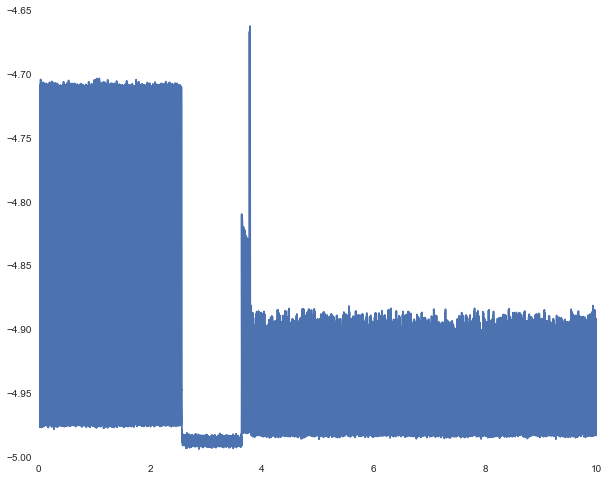

In [59]:
# show first 10 seconds
disp_frames = int(10 * header['fs'])
plot(np.linspace(0, 10, disp_frames), raw_data[:disp_frames])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


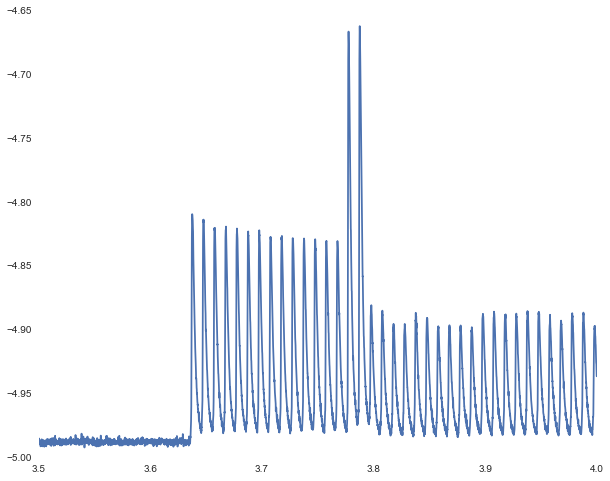

In [60]:
# show 3.5 to 4 seconds
disp_frames_start = 3.5 * header['fs']
disp_frames_end   = 4 * header['fs']
plot(np.linspace(3.5, 4, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


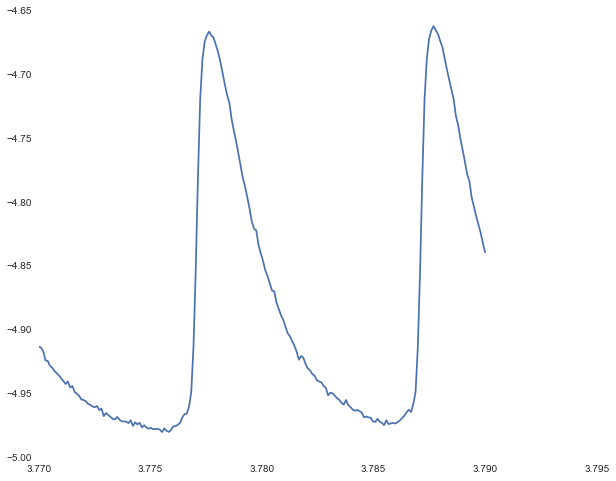

In [61]:
# show 3.77 to 3.79 seconds
disp_frames_start = 3.77 * header['fs']
disp_frames_end   = 3.79 * header['fs']
plot(np.linspace(3.77, 3.79, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

In [62]:
first_white_peak  = np.argmax(raw_data[3.77 * header['fs'] : 3.785 * header['fs']])
first_white_ind   = first_white_peak + 3.77 * header['fs']
time_stim_started = first_white_ind / header['fs']
print 'Stimulus started at %f seconds, relative to recording computer' %(time_stim_started)

Stimulus started at 3.777600 seconds, relative to recording computer


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


# Load spikes

In [63]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - time_stim_started for spike in spikes if (not (not spike)) and float(spike) - time_stim_started > 0])
    
    text_file.close()

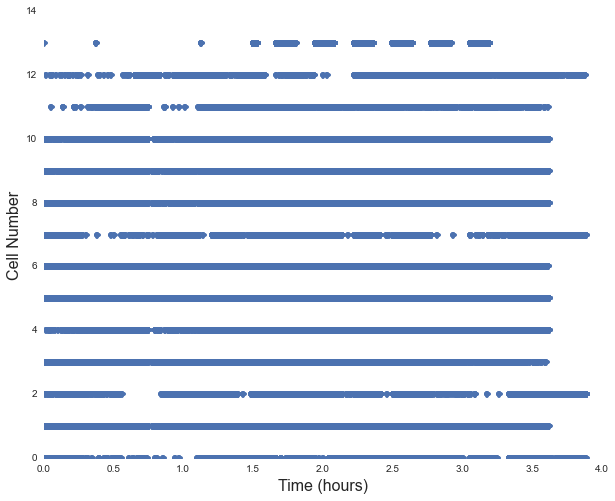

In [64]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plot(all_spiking[:,0]/(3600.), all_spiking[:,1], 'o')
xlabel('Time (hours)', fontsize=16)
ylabel('Cell Number', fontsize=16)

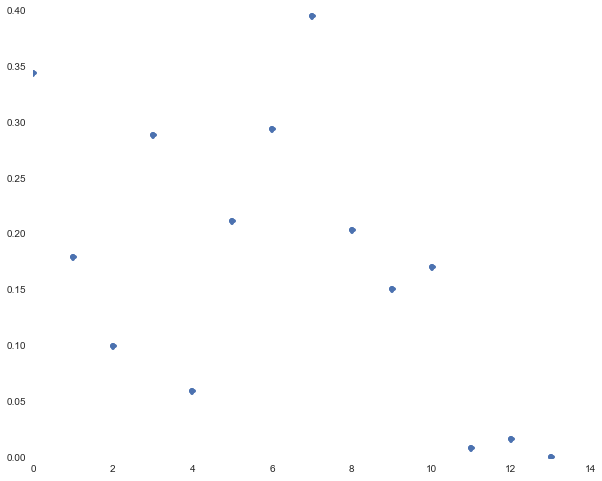

In [65]:
avg_spike_rate = [len(np.array(cells[i])[np.array(cells[i]) < 22.5*60.])/(22.5*60.) for i in range(len(cells))]
plot(avg_spike_rate, 'o')

# Reconstruct natural scenes stimulus  
To naively reconstruct the stimulus frame-by-frame would be >70 GB, so instead we're just going to store the jitter, centers, and image indices.  

Expt5 is natural scenes.  
Expt6 through Expt15 are repeats of the first 1 min of the natural scenes stimulus.  

The HDF5 file in expt5/stim is (nframes, 3) array where dimensions are (image index, xstart, ystart), respectively.

## Load data

In [148]:
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/natural_scenes_stimulus_norepeats.h5')
f = h5py.File(stim_file)

In [67]:
f.keys()

[u'expt5', u'images']

In [68]:
f['expt5'].keys()

[u'stim', u'timestamps']

#### why are some of the images the same?

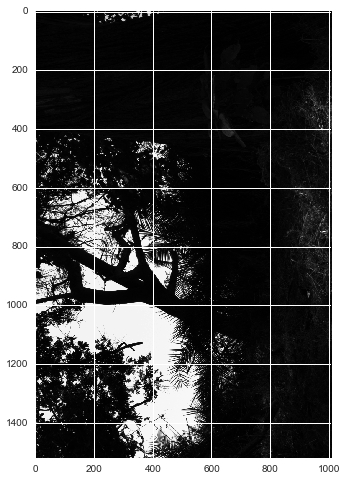

In [69]:
imshow(f['images'][0])

In [70]:
np.max(f['expt5/timestamps'])

5508.4455000000307

In [71]:
np.max(all_spiking)

13995.6787

In [72]:
from __future__ import division
def rescale(x):    
    # note that if python3 division isn't being used, integers will be truncated
    xmin = np.min(x)
    xmax = np.max(x)
    return (x - xmin) / (xmax - xmin)

class NaturalScenesStimulus(object):
    '''Take the compressed natural scenes data and return the appropriate frame(s).'''

    def __init__(self, images, stimulus):
        '''Images should be (num_images, height, width).
        Stimulus should be (num_frames, 3) where the three
        dimensions refer to image index, xstart, ystart.'''
        self.images = images
        self.stimulus = stimulus
        self.ndims = 500

    def __getitem__(self, index):
        #pdb.set_trace()
        img_index = self.stimulus[index, 0].astype('int')
        xstart = self.stimulus[index, 1].astype('int')
        ystart = self.stimulus[index, 2].astype('int')
        # Need to check if index is integer or iterable
        try:
            # assume index is a slice
            imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
            return np.array([2*img[y:y+self.ndims, x:x+self.ndims] for x,y,img in zip(xstart,ystart,imgs)])
        except:
            # otherwise index is an integer
            img = rescale(self.images[img_index])
            return img[ystart:ystart+self.ndims, xstart:xstart+self.ndims]

In [73]:
natural_stimuli = NaturalScenesStimulus(f['images'], f['expt5/stim'])

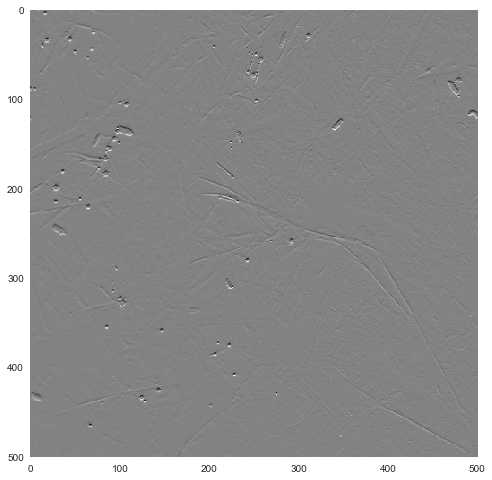

In [155]:
imshow(natural_stimuli[1:5][1] - natural_stimuli[1:5][0])
plt.grid(False)

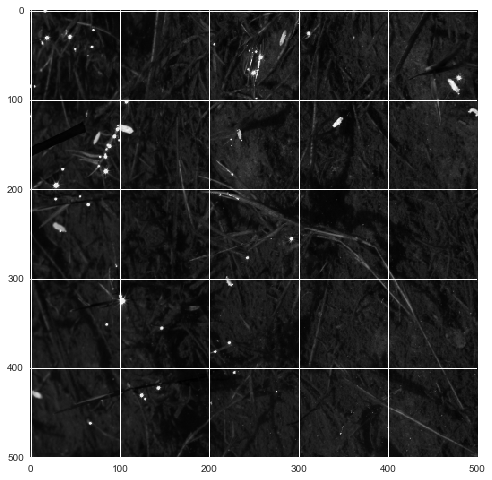

In [75]:
imshow(natural_stimuli[0])

# Load repeats

In [76]:
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/natural_scenes_stimulus_repeats.h5')
g = h5py.File(stim_file)

In [77]:
g.keys()

[u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [78]:
g['expt10'].keys()

[u'stim', u'timestamps']

In [79]:
g['expt10/timestamps'][:]

array([  0.00000000e+00,   2.00000000e-02,   4.00000000e-02, ...,
         6.11423000e+01,   6.11623000e+01,   6.11823000e+01])

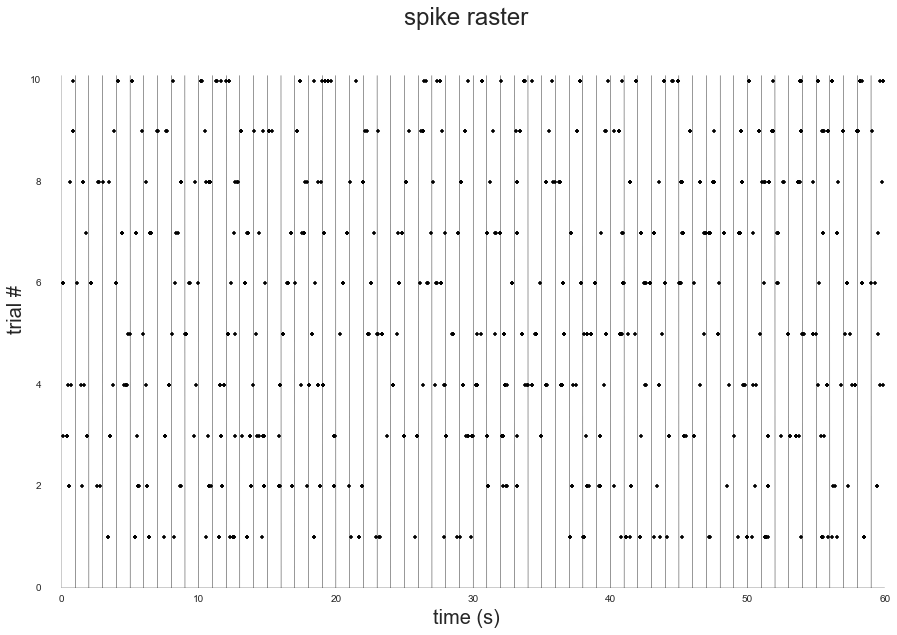

In [80]:
# 4 periods of white noise, then 90 min of natural scenes without repeats, then 1 min repeats of natural scenes
cell_idx = 5
num_trials = 10
start_trials_time = 60 * (4 * 22.5 + 90)
end_trials_time = start_trials_time + 60 * (num_trials * 1)
relevant_spikes = np.array(cells[cell_idx]) - start_trials_time
relevant_spikes = relevant_spikes[relevant_spikes > 0]
relevant_spikes = relevant_spikes[relevant_spikes <= 60. * (num_trials * 1.)]

spikes = relevant_spikes
trial_length=60.

# Compute the time indices of each trial
times = np.array([np.array([0, trial_length]) + trial_length * i
                   for i in np.arange(np.ceil(spikes.max() / trial_length))])

# Plot each trial
fig = plt.gcf()
fig.set_size_inches((15,10))
ax = fig.add_subplot(111)
for trial in range(times.shape[0]):
    idx = np.bitwise_and(spikes > times[trial, 0], spikes <= times[trial, 1])
    ax.plot(spikes[idx] - times[trial, 0], (trial + 1) * np.ones((idx.sum(), 1)),
            color='k', linestyle='none', marker='.')

# Labels, etc.
plt.title('spike raster', fontdict={'fontsize': 24})
plt.xlabel('time (s)', fontdict={'fontsize': 20})
plt.ylabel('trial #', fontdict={'fontsize': 20})
plt.ylim(ymin=0, ymax=times.shape[0] + 1)
plt.xlim([-1, 60])

resolution = 1000
new_images = np.zeros((60*resolution,))
new_images[::resolution] = 1
ax.plot(np.linspace(0,60.,60*resolution), 10.1 * new_images, 'k', linewidth=0.2)

In [81]:
end_trials_time + 5*60

11700.0

In [82]:
np.max(cells[0])

13982.559000000001

## Let's more precisely align times

#### Add time from the first 4 white noise experiments

In [83]:
stim_file_wn = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/stimulus.h5')
wn = h5py.File(stim_file_wn)

In [84]:
wn.keys()

[u'expt1', u'expt2', u'expt3', u'expt4']

In [85]:
duration = []
for key in wn.keys():
    duration.append(wn[key+'/timestamps'][-1])

In [86]:
sum(duration)/60.

90.006348333332184

#### Add time from the first natural scenes experiment

In [87]:
duration.append(f['expt5/timestamps'][-1])

In [88]:
transition_duration = wn['expt1/timestamps'][1]
num_transitions = 5 # before expt6 (start of natural scene repeats)
start_of_first_natural_scenes_repeats = sum(duration) + num_transitions * transition_duration
start_of_first_natural_scenes_repeats

10908.926399999764

In [89]:
length_of_each_trial = g['expt6/timestamps'][-1] + transition_duration
length_of_each_trial

61.202299999946263

(0, 11)

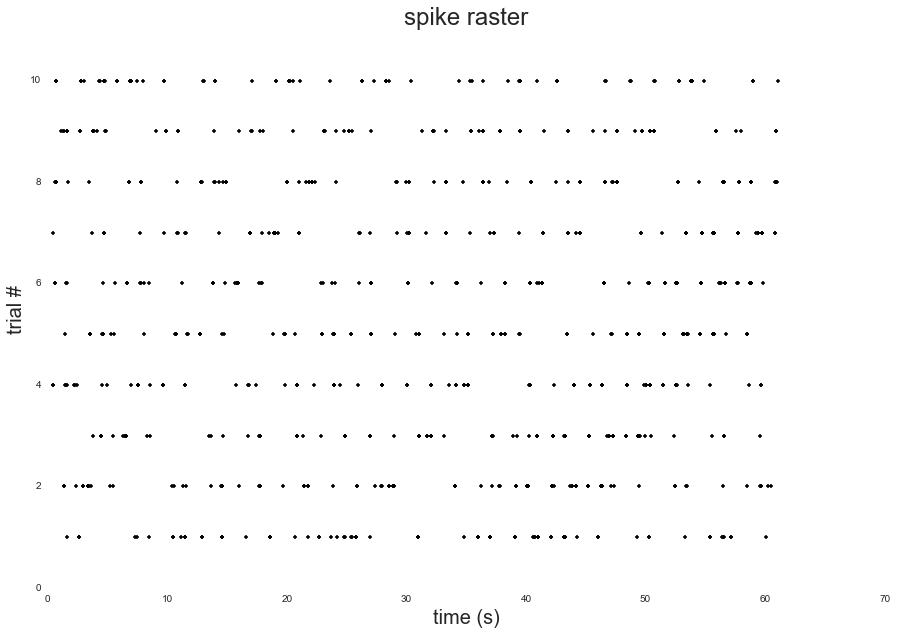

In [90]:
# 4 periods of white noise, then 90 min of natural scenes without repeats, then 1 min repeats of natural scenes
cell_idx = 5
num_trials = 10
relevant_spikes = np.array(cells[cell_idx]) - start_of_first_natural_scenes_repeats
relevant_spikes = relevant_spikes[relevant_spikes > 0]
relevant_spikes = relevant_spikes[relevant_spikes <= num_trials * length_of_each_trial]

spikes = relevant_spikes
trial_length=length_of_each_trial #+ 3.1

# Compute the time indices of each trial
times = np.array([np.array([0, trial_length]) + trial_length * i
                   for i in np.arange(np.ceil(spikes.max() / trial_length))])

# Plot each trial
fig = plt.gcf()
fig.set_size_inches((15,10))
ax = fig.add_subplot(111)
for trial in range(times.shape[0]):
    idx = np.bitwise_and(spikes > times[trial, 0], spikes <= times[trial, 1])
    ax.plot(spikes[idx] - times[trial, 0], (trial + 1) * np.ones((idx.sum(), 1)),
            color='k', linestyle='none', marker='.')

# Labels, etc.
plt.title('spike raster', fontdict={'fontsize': 24})
plt.xlabel('time (s)', fontdict={'fontsize': 20})
plt.ylabel('trial #', fontdict={'fontsize': 20})
plt.ylim(ymin=0, ymax=times.shape[0] + 1)
# plt.xlim([-1, 62])

# resolution = 1000
# new_images = np.zeros((60*resolution,))
# new_images[::resolution] = 1
# ax.plot(np.linspace(0,60.,60*resolution), 10.1 * new_images, 'k', linewidth=0.2)

In [91]:
length_of_each_trial

61.202299999946263

In [149]:
trial_length

64.282299999985838

In [153]:
wn['expt1/timestamps'][1]

0.019999999960418791

In [155]:
f['expt5/timestamps'][1]

0.020100000023376197

In [156]:
g['expt6/timestamps'][1]

0.019999999960418791

In [167]:
len(g['expt6/stim'])

2999

In [170]:
g['expt6/timestamps'][-1]

61.182299999985844

In [171]:
61.1822/2999

0.020400866955651884

In [175]:
1./np.mean(np.diff(g['expt6/timestamps']))

49.001099991348703

In [176]:
yada = np.cumsum(np.diff(g['expt6/timestamps']))

In [177]:
yada

array([  2.00000000e-02,   4.00000000e-02,   6.00000000e-02, ...,
         6.11423000e+01,   6.11623000e+01,   6.11823000e+01])

In [179]:
g['expt6/timestamps'][:]

array([  0.00000000e+00,   2.00000000e-02,   4.00000000e-02, ...,
         6.11423000e+01,   6.11623000e+01,   6.11823000e+01])

In [180]:
len(yada)

2998

In [181]:
g['expt7/timestamps'][-1]

61.182399999990594

# Use photodiode to align each trial, since no timestamps in between expts

In [25]:
photodiode_dir = '/Volumes/data/Lane/2015-07-02/'

In [26]:
bin_file_suffices = string.ascii_lowercase[:14]

In [27]:
bin_file_suffices

'abcdefghijklmn'

In [ ]:
'150702' 

In [ ]:
first_bin_file = data_dir + '150702a.bin'
raw_data = binary.readbin(first_bin_file, chanlist=[0])
header   = binary.readbinhdr(first_bin_file)

In [6]:
indices = peakdet(raw_data, delta=0.15)

In [8]:
max_indices = indices[0]

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


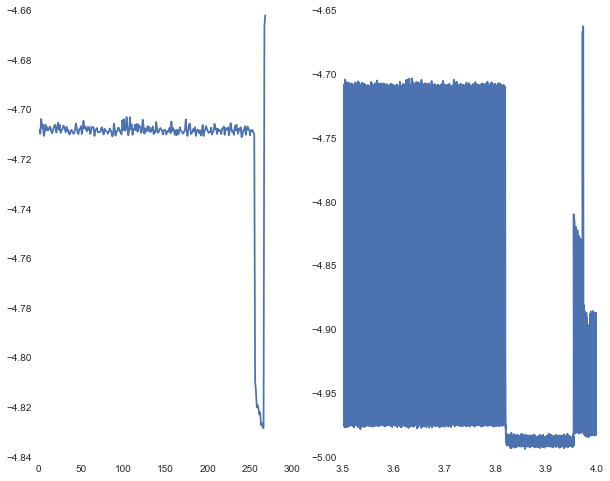

In [23]:
plt.subplot(1,2,1)
plot(raw_data[max_indices[:,0].astype('int')])
plt.subplot(1,2,2)
disp_frames = int(10 * header['fs'])
# show 3.5 to 4 seconds
disp_frames_start = 0 * header['fs']
disp_frames_end   = 4 * header['fs']
plot(np.linspace(3.5, 4, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

In [29]:
data_dir

'/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/'

In [ ]:
for letter in bin_file_suffices:
    bin_filename = '150702%s.bin' %(letter)
    bin_file = data_dir + bin_filename
    raw_data = binary.readbin(bin_file, chanlist=[0])
    

In [32]:
raw_data2 = binary.readbin(data_dir + '150702b.bin', chanlist=[0])

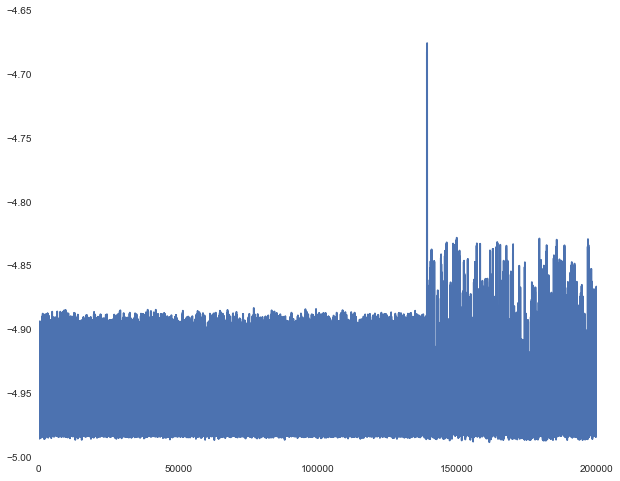

In [40]:
plot(raw_data2[3400000:3600000])

# Save photodiode white frames to file

In [14]:
# import time
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')
experiment_date = '150702'
white_threshold = -4.7
num_bin_files = 14
bin_file_suffices = string.ascii_lowercase[:num_bin_files]
fs = 10000.0 # Hz
bin_file_duration = 1000.0 # seconds

# store timestamps of each white frame
white_frame_timestamps = []

# for each bin file
for idl, letter in enumerate(bin_file_suffices):
    # load bin files
    bin_filename = '%s%s.bin' %(experiment_date, letter)
    bin_file = data_dir + bin_filename
    raw_data = binary.readbin(bin_file, chanlist=[0])
    
    # Get snippets of local maxima that cross white_threshold
    indices_passing_thresh = np.argwhere(raw_data > white_threshold)[:,0]
    if len(indices_passing_thresh) > 0:
        start_of_white_frame = [indices_passing_thresh[0]]
        end_of_white_frame = []
        for idd, d in enumerate(np.diff(indices_passing_thresh)):
            if d > 1:
                start_of_white_frame.append(indices_passing_thresh[idd+1])
                end_of_white_frame.append(indices_passing_thresh[idd])
        end_of_white_frame.append(indices_passing_thresh[-1])
        if len(start_of_white_frame) != len(end_of_white_frame):
            raise Exception('Have %d starts but %d ends to local maxima.' \
                    %(len(start_of_white_frame), len(end_of_white_frame)))

        for start, end in zip(start_of_white_frame, end_of_white_frame):
            if end - start == 0:
                peak = start
            else:
                snippet = raw_data[start:end]
                try:
                    peak = start + np.argmax(snippet)
                except:
                    pdb.set_trace()
            # append time in current file + time that was in previous bin files
            #print (letter, (peak/fs + idl*bin_file_duration)/60., (peak/fs + idl*bin_file_duration)/3600.)
            #fig = plt.gcf()
            #ax = plot(raw_data[start-10000:start+10000])
            #plt.show()
            #time.sleep(2)
        
            white_frame_timestamps.append(peak/fs + idl*bin_file_duration)

save_filename = data_dir + 'photodiode_white_frame_timestamps.txt'
np.savetxt(save_filename, white_frame_timestamps, fmt='%10.6f')

# Load photodiode white frames

In [19]:
white_frames = np.loadtxt(data_dir + 'photodiode_white_frame_timestamps.txt')

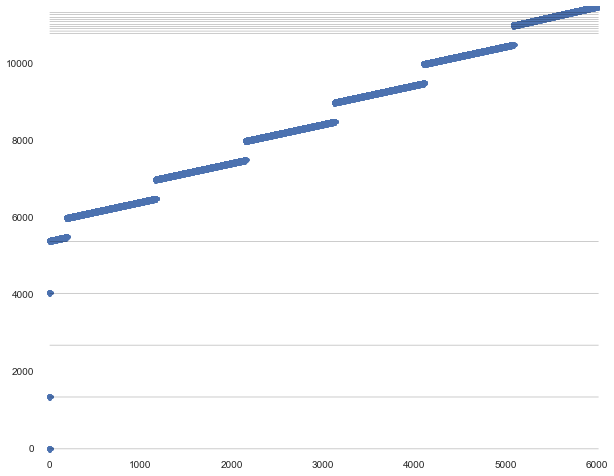

In [36]:
plot(white_frames, 'o')
# expt1
plot(0*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt2
plot(60*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt3
plot(60*2*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt4
plot(60*3*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt5
plot(60*4*22.5*np.ones(len(white_frames)),'k', linewidth=0.2)
# expt6 to expt15
for expt in range(10):
    plot(60*(4*22.5+90+expt)*np.ones(len(white_frames)),'k', linewidth=0.2)
tmp = plt.xlim([-100, len(white_frames)])
tmp = plt.ylim([-100, np.max(white_frames)])

In [93]:
plot(white_frames[5000:], 'o')
mpld3.display()

In [43]:
11000./60. - 4*22.5 - 90

3.333333333333343

In [44]:
60*(4*22.5 + 90)

10800.0

In [45]:
white_frames[-1]

11499.914500000001

In [46]:
white_frames[white_frames > 10800][0]

11000.684999999999

In [48]:
(white_frames[-1] - white_frames[white_frames > 10800][0])/60.

8.3204916666666886

In [117]:
trial_starts = white_frames[white_frames > 10800][1:][np.diff(white_frames[white_frames > 10800]) > 2]
trial_starts = np.insert(trial_starts, 0, white_frames[white_frames > 10800][0])
trial_starts = np.append(trial_starts, trial_starts[-1]+np.diff(trial_starts)[-1])

In [119]:
trial_starts

array([ 11000.685 ,  11047.6479,  11111.973 ,  11176.2881,  11240.593 ,
        11304.918 ,  11369.2331,  11433.5481,  11497.8631,  11562.1781])

In [118]:
np.diff(trial_starts)

array([ 46.9629,  64.3251,  64.3151,  64.3049,  64.325 ,  64.3151,
        64.315 ,  64.315 ,  64.315 ])

In [102]:
np.sum(np.diff(trial_starts)) + np.mean(np.diff(trial_starts))

514.53165714285774

In [108]:
trial_starts[0]

11047.6479

In [107]:
trial_starts[-1]

11497.8631

In [115]:
trial_starts[-1] - trial_starts[0] + np.diff(trial_starts)[-1]

561.4931000000015

In [116]:
len(trial_starts)

9

(-1, 62)

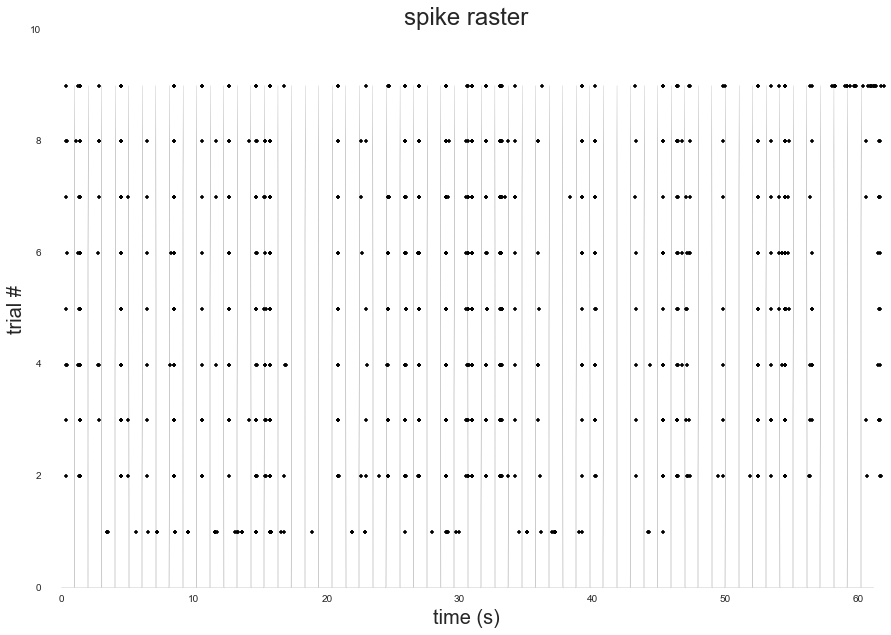

In [146]:
# 4 periods of white noise, then 90 min of natural scenes without repeats, then 1 min repeats of natural scenes
cell_idx = 5
num_trials = 9
# relevant_spikes = np.array(cells[cell_idx]) - trial_starts[0]
# relevant_spikes = relevant_spikes[relevant_spikes > 0]
# relevant_spikes = relevant_spikes[relevant_spikes <= np.sum(np.diff(trial_starts)) + np.mean(np.diff(trial_starts))]

# spikes = relevant_spikes
# trial_length=length_of_each_trial #+ 3.1

spikes = np.array(cells[cell_idx])

# Plot each trial
fig = plt.gcf()
fig.set_size_inches((15,10))
ax = fig.add_subplot(111)
for trial in range(num_trials):
    # Compute the time indices of each trial
    idx = np.bitwise_and(spikes > trial_starts[trial], spikes <= trial_starts[trial+1])
    ax.plot(spikes[idx] - trial_starts[trial], (trial + 1) * np.ones((idx.sum(), 1)),
            color='k', linestyle='none', marker='.')
    
# plot when image changes
plot(g['expt7/timestamps'][1:], num_trials*np.sign(np.abs(np.diff(g['expt7/stim'][:,0]))), 'k', linewidth=0.1)

# Labels, etc.
plt.title('spike raster', fontdict={'fontsize': 24})
plt.xlabel('time (s)', fontdict={'fontsize': 20})
plt.ylabel('trial #', fontdict={'fontsize': 20})
plt.ylim(ymin=0, ymax=num_trials+1)
plt.xlim([-1, 62])

# resolution = 1000
# new_images = np.zeros((60*resolution,))
# new_images[::resolution] = 1
# ax.plot(np.linspace(0,60.,60*resolution), 10.1 * new_images, 'k', linewidth=0.2)

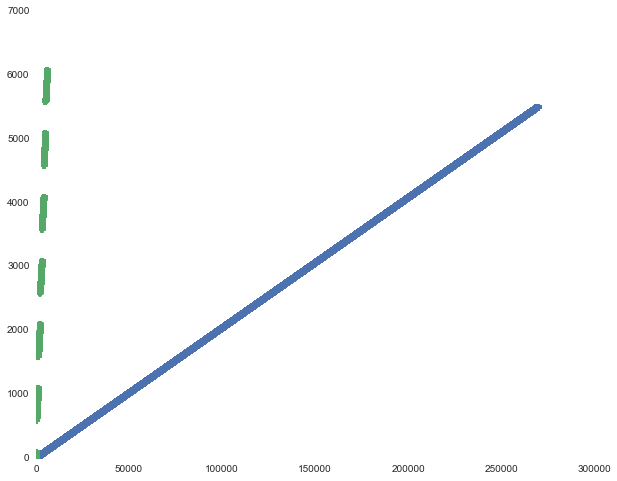

In [153]:
plot(f['expt5/timestamps'], 'o')
plot(white_frames[8:6000] - white_frames[8], 'o')